In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import sparse
from sklearn.datasets import make_sparse_spd_matrix

In [2]:
def GABP(AMat, BVec, lam):
    """
    Function that implements Gaussian belief propagation
    Inputs:
        AMat: precision matrix
        BVec: bias vector
        lam: relaxation for updates, between 0 and 1
        p(x) = k.exp(-0.5x'Ax + b'x)
   
    Outputs: 
        InferredPrec: vector of marginal precisions
        InferredBias: vector of marginal biases    
        InferredPrecMat: time series of marginal precisions
        InferredBiasMat: time series of marginal biases
    """
    
    N = AMat.shape[0]
    
    Ad = (AMat != 0)*1 - np.eye(N) #adjacency matrix 
    
    # initialize the precision and biases of the messages
    # P[i,j] corresponds to message sent from node i to node j
    P    = np.zeros([N,N])
    V    = np.zeros([N,N])
    # P = (0.4*np.random.rand(N,N)-0.2)*Ad
    # V = np.random.randn(N,N)*Ad  
    Pnew = np.zeros([N,N])
    Vnew = np.zeros([N,N])
    
    T = 500 # max no. of iteration
    eps = 1e-6 #tolerance for convergence
    
    InferredPrec    = np.zeros([N])
    InferredBias    = np.zeros([N])
    InferredPrecMat = np.zeros([N,T+1])
    InferredBiasMat = np.zeros([N,T+1])
    
    CostVec = np.zeros([T]) # cost is norm(m(t) - m(t-1)) 
    
    InferredPrecMat[:,0] = np.diag(AMat) + np.sum(P,axis=0)
    InferredBiasMat[:,0] = BVec + np.sum(V,axis=0)
    
    for t in range(T):
        for i in range(N):
            for j in range(N):
                if Ad[i,j]:
                    # update message parameters
                    alpha = AMat[i,i] + np.sum(P[:,i]) - P[j,i]
                    beta = BVec[i] + np.sum(V[:,i]) - V[j,i]
                    Pnew[i,j] = (1-lam)*P[i,j] -lam*AMat[i,j]**2/alpha
                    Vnew[i,j] = (1-lam)*V[i,j] -lam*AMat[i,j]*beta/alpha
                    
        # now compute the beliefs
        InferredPrec = np.diag(AMat) + np.sum(Pnew,axis=0)
        InferredBias = BVec + np.sum(Vnew,axis=0)
        InferredPrecMat[:,t+1] = 1*InferredPrec
        InferredBiasMat[:,t+1] = 1*InferredBias
        
        # Check if the messages have converged
        OldParams = np.concatenate([P.flatten(), V.flatten()])
        NewParams = np.concatenate([Pnew.flatten(), Vnew.flatten()])
        RMSE = np.linalg.norm(OldParams - NewParams)/np.sqrt(np.sum(Ad)) 
        CostVec[t] = RMSE
            
        P = 1*Pnew
        V = 1*Vnew 
        
        if  RMSE <= eps:
            print('Converged in', t, 'iterations')
            break
        
        
    return InferredPrec, InferredBias, InferredPrecMat[:,0:t+1], InferredBiasMat[:,0:t+1], CostVec[0:t]

# Run GABP for an example

In [3]:
# Set noise seed
noise_seed = np.random.randint(10000)
print('noise_seed =', noise_seed)
np.random.seed(seed=noise_seed)

# Create input data

N = 40 # no. of variables
AMat = make_sparse_spd_matrix(dim=N, alpha=0.8, smallest_coef=0.1,largest_coef=0.25) # random, sparse precision matrix 
AMat = AMat + 0.2*np.eye(N)

# # Inspect eigenvalues of AMat
# E = np.linalg.eigvals(A)
print("cond no. of AMat = %.2f" %np.linalg.cond(AMat))

BVec = np.random.randn(N) # bias vector

# Compute the parameters of the true marginals 
# expectation parameters
TrueVar = np.diag(np.linalg.inv(AMat))
TrueMean = np.linalg.solve(AMat,BVec)
# natural parameters
TruePrec = 1/TrueVar
TrueBias = TrueMean*TruePrec

noise_seed = 4310
cond no. of AMat = 6.83


In [4]:
InferredPrec, InferredBias, InferredPrecMat, InferredBiasMat, CostVec = GABP(AMat,BVec,lam=0.25)
InferredMean = InferredBias/InferredPrec
InferredVar = 1/InferredPrec

Converged in 56 iterations


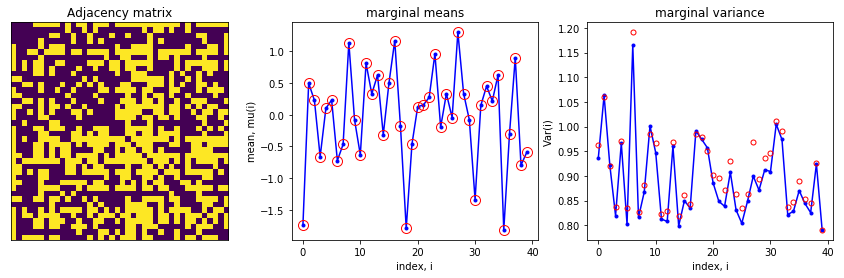

In general, marginal means are inferred correctly, but the variances are NOT.
The variances are inferred correctly only for trees.


In [5]:
# Plot results
# Note that in GABP, inferred mean matches the true mean

fig, ax = plt.subplots(1,3,figsize=(15,4))

ax[0].imshow((AMat!=0)*1 - np.eye(N))
ax[0].set(title='Adjacency matrix') 
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].plot(TrueMean,'b.-')
ax[1].plot(InferredMean,'ro',Markersize = 10,fillstyle='none')
ax[1].set(xlabel='index, i', ylabel='mean, mu(i)', title = 'marginal means')

ax[2].plot(TrueVar,'b.-')
ax[2].plot(InferredVar,'ro',Markersize = 5,fillstyle='none')
ax[2].set(xlabel='index, i', ylabel='Var(i)', title = 'marginal variance')
plt.show()

print('In general, marginal means are inferred correctly, but the variances are NOT.')
print('The variances are inferred correctly only for trees.')

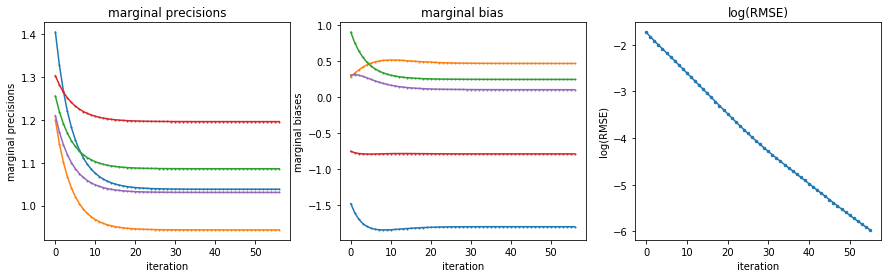

In [6]:
# Plot the dynamics
fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].plot(InferredPrecMat[0:5,:].T,'.-',markersize=2)
ax[0].set(xlabel='iteration', ylabel='marginal precisions', title = 'marginal precisions')
ax[1].plot(InferredBiasMat[0:5,:].T,'.-',markersize=2)
ax[1].set(xlabel='iteration', ylabel='marginal biases', title = 'marginal bias')
ax[2].plot(np.log10(CostVec),'.-',markersize=5)
ax[2].set(xlabel='iteration', ylabel='log(RMSE)', title = 'log(RMSE)')
plt.show()